# RPS Nanopore Particle Sizing Algorithm 
### Chris McAllister 

* Importing Modules 

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

* Defining a test sigma value

In [2]:
test_sig = 1.264

## *Part 1 - Calculating Resistance Changes* 

* Function for calculating B Values

In [3]:
def calc_b_values(rtip, xpart, rpart, a):
    """Calculates B values for Resistance Change calculations from 
    Gyurcsanyi Analytical Chem 2014, 86(10), 4688-4697 SI
    
    inputs: pipet tip radius, position of particle center, 
    particle radius, neccessary angle
    
    outputs: B values in an array (b3 is squared)
    -------------------------------------------------------------------------"""
    # Degrees to Rad
    angle = a * np.pi/180
    # Calculating B values 
    b1 = (1-np.cos(angle)**2)*xpart**2 - np.sin(2*angle)*rtip*xpart+np.cos(angle)**2 * rtip**2 - rpart**2
    b2 = (np.cos(angle)**2 - 1)*xpart + np.cos(angle)*np.sin(angle)*rtip
    b3_sq = (np.tan(angle)**2+1)*rpart**2 - (np.tan(angle)*xpart - rtip)**2
    b4 = np.tan(angle)**2*xpart - np.tan(angle)*rtip - (np.tan(angle)**2 + 1)*rpart
    b5 = xpart = np.tan(angle)*rtip
    return [b1, b2, b3_sq, b4, b5]

In [4]:
calc_b_values(110e-9, -100e-9, 50e-9, 8)

[1.259133569472223e-14,
 1.7096969773019e-08,
 -1.284003631009395e-14,
 -6.84222507500898e-08,
 1.5459491817263062e-08]

* Function for calculating delta R-partial 

In [5]:
def calc_delta_r_part(rtip, xpart, rpart, angle, sigma):
    """Calculating delta r for the particle being partially inside of the pipette
    
    inputs: pipet tip radius, position of particle center, 
    particle radius, cone angle, bulk conductivity value
    
    output: delta R-part value"""
    ang = angle * np.pi/180
    beta= 54.8 * np.pi/180 
    
    # Negating xpart for pipette calculations 
    xpp = -1 * xpart
    
    # Calculating B Values (access)
    bvals = calc_b_values(rtip, xpart, rpart, beta)
    b1 = bvals[0]
    b2 = bvals[1]
    b3_sqr = bvals[2]
    b3 = np.sqrt(b3_sqr)
    b4 = bvals[-2]
    b5 = bvals[-1]
    
    # Calculating B Values (pipette)
    bvals_p = calc_b_values(rtip, xpp, rpart, angle)
    b1p = bvals_p[0]
    b2p = bvals_p[1]
    b3_sqr_p = bvals_p[2]
    b3p = np.sqrt(b3_sqr)
    b4p = bvals_p[-2]
    b5p = bvals_p[-1]
    
    # Calculating Ro access
    num1 = rpart - xpart
    denom1 = sigma * np.pi * rtip * (np.tan(beta)*(num1) + rtip)
    Roa = num1 / denom1
    
    # Calculating Ro pipette
    num2 = rpart - xpp
    denom2 = sigma * np.pi * rtip * (np.tan(ang)*(num2) + rtip)
    Rop = num2 / denom2
    
    # Calculating R access
    if b3_sqr < 0:
        fx1 = np.cos(beta)*xpart
        fx2 = np.sin(beta)*rtip
        fx3 = np.arctan((fx1+fx2)/np.sqrt(b1))
        fx4 = np.cos(beta)*np.sqrt(b1) 
        fx5 = np.arctan((b2+rpart)/fx4)
        num = -1 *np.cos(beta)*(fx3 - fx5)
        denom = np.pi * sigma * np.sqrt(b1)
        Ra = num / denom 
    if b3_sqr > 0: 
        fx1 = np.abs(b3 + b4)
        fx2 = np.abs(b3 - b4)
        fx3 = np.abs(b3 + b5)
        fx4 = np.abs(b3 - b5)
        num = np.log((fx1*fx3)/(fx2*fx4))
        denom = 2 * sigma * np.pi * b3
        Ra = num / denom
    else:
        pass
    
    # Calculating R pipette
    if b3_sqr_p < 0:
        fx1 = np.cos(ang)* xpp
        fx2 = np.sin(ang)*rtip
        fx3 = np.arctan((fx1+fx2)/np.sqrt(b1p))
        fx4 = np.cos(ang)*np.sqrt(b1p) 
        fx5 = np.arctan((b2p+rpart)/fx4)
        num = -1 *np.cos(ang)*(fx3 - fx5)
        denom = np.pi * sigma * np.sqrt(b1p)
        Rp = num / denom 
    if b3_sqr_p > 0: 
        fx1 = np.abs(b3p + b4p)
        fx2 = np.abs(b3p - b4p)
        fx3 = np.abs(b3p + b5p)
        fx4 = np.abs(b3p - b5p)
        num = np.log((fx1*fx3)/(fx2*fx4))
        denom = 2 * sigma * np.pi * b3p
        Rp = num / denom
    else:
        pass
    
    # Calculating delta R
    Ro = Roa + Rop
    R = Ra + Rp
    delta_R = R - Ro
    return delta_R

In [6]:
calc_delta_r_part(110e-9, -50e-9, 50e-9, 8, test_sig)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


-637946.5682593797

* Function for calculating Delta R-out

In [7]:
def calc_delta_r_out(rtip, xpart, rpart, angle, sigma):
    """Calculating delta r for the particle being completely outside/inside of the pipette
    
    inputs: pipet tip radius, position of particle center, 
    particle radius, cone angle, bulk conductivity value
    
    output: delta R-out value"""
    ang = angle * np.pi/180
    
    # Calculating B Values
    bvals = calc_b_values(rtip, xpart, rpart, angle)
    b1 = bvals[0]
    b2 = bvals[1]
    
    # Setting limits of integration for Ro
    low_lim = xpart - rpart
    up_lim = xpart + rpart
    
    # Calculating Ro
    a = rtip
    b = np.tan(ang)
    def f(x):
        return (np.pi * sigma * (a - b*x)**2)**-1
    Ro, err = integrate.quad(f, low_lim, up_lim)
    
    # Calculating R
    fx1 = np.arctan((b2-rpart)/(np.cos(ang)*np.sqrt(b1)))
    fx2 = np.arctan((b2+rpart)/(np.cos(ang)*np.sqrt(b1)))
    num = np.cos(ang) * (fx1 - fx2)
    den = sigma * np.pi * np.sqrt(b1)
    R = - num / den
    
    # Calculating delta R
    delta_R = R - Ro
    return delta_R

In [8]:
calc_delta_r_out(110e-9, -100e-9, 50e-9, 54.8, test_sig)

12762.147061240626

* Function for calculating Delta R based on a given particle size 

In [9]:
def calc_delta_r(rtip, xpart, rpart, alpha, sigma): 
    """Uses B values from previous function to calculate delta R for a given set of parameters 
    
    inputs: pipet tip radius, position of particle center, 
    particle radius, cone angle, bulk conductivity value
    
    output: delta R value
    -------------------------------------------------------------------------------"""
    beta = 54.8
    if xpart <= -rpart:
        delta_R = calc_delta_r_out(rtip, xpart, rpart, beta, sigma) 
    if -rpart <= xpart <= rpart:
        delta_R = calc_delta_r_part(rtip, xpart, rpart, alpha, sigma)
    if xpart >= rpart:
        delta_R = calc_delta_r_out(rtip, -1 * xpart, rpart, alpha, sigma)
    else:
        pass
    return delta_R

In [10]:
calc_delta_r(110e-9, 49e-9, 50e-9, 8, test_sig)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


42143.869938885095

* Function to convert Delta R values calculated above into R-peak*

In [11]:
def calc_R_peak(rtip, xpart, rpart, alpha, sigma):
    """Converts delta R value into a "delta I over I" value than can be
    compared to an experimental RPS response
    
    inputs: pipet tip radius, position of particle center, 
    particle radius, cone angle, bulk conductivity value
    
    output: delta I over I value"""
    angle = alpha * np.pi/180
    
    # Calculating Delta R
    dR = calc_delta_r(rtip, xpart, rpart, alpha, sigma)
    
    # Calculating R 
    dtip = 2 * rtip 
    term1 = 2 / (np.pi * sigma * dtip * np.tan(angle))
    term2 = 1 / (2 * dtip * sigma)
    R = term1 + term2
    
    # Calculating Current Blockage 
    CB = - dR / (R + dR)
    
    # Calculating R-peak
    R_peak = - R * CB / (CB + 1)
    
    # Calculating R-peak*
    R_peak_f = sigma * dtip * R_peak
    
    return R_peak_f

In [12]:
calc_R_peak(110e-9, 50e-9, 100e-9, 12, test_sig)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


0.9017746373343771

* Function to vary xpart and find the maximum Rpeak value for the translocation event 

In [13]:
def find_max_R_peak(rtip, rpart, alpha, sigma):
    """Varies xpart argument in calc_R_peak 
    and exports the maximum R-peak* value
    
    Inputs: tip radius, particle radius, 
    cone angle, bulk conductivity value
    
    Output: maximum R-peak* value 
    -----------------------------------------------------------"""
    # Setting range for xpart
    lower_x = -2 * rpart
    upper_x = 2 * rpart 
    xrange = np.arange(start = lower_x, stop = upper_x, step = 1e-9)
    
    # Creating empty array for Rpeak* values
    rpeak_arr = []
    
    # Iterating through xrange to calculate Rpeak* values 
    # at different particle positions
    for i in xrange:
        rpeak_val = calc_R_peak(rtip, i, rpart, alpha, sigma)
        rpeak_arr.append(rpeak_val)
    
    rp_f = np.nanmax(rpeak_arr)
    return rp_f

In [14]:
find_max_R_peak(110e-9, 100e-9, 12, test_sig)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


0.9359864766984538

## *Part 2 - Simulation*

In [15]:
def simulate_variable_particle_size(rtip, alpha, sigma): 
    """Finds the max Rpeak* values for a range of particle sizes"""
    # Creating axis 
    ratios = np.arange(start = 0.01, stop = 0.9, step = 0.01)
    rparts = ratios * rtip 
    
    # Creating empty list to store values 
    rpeak_list = []
    
    # Generating Axis values
    for i in rparts:
        rpeak_val = find_max_R_peak(rtip, i, alpha, sigma)
        rpeak_list.append(rpeak_val)
    
    # Turning list of Rpeak values into an array
    rpeaks = np.array(rpeak_list)
    return rpeaks

In [16]:
simulate_variable_particle_size(110e-9, 3, 1.0)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


array([8.45988870e-07, 6.75924040e-06, 2.27868785e-05, 5.38589306e-05,
       1.05109171e-04, 1.81512678e-04, 2.87550198e-04, 4.29093227e-04,
       6.10859508e-04, 8.36352959e-04, 1.11337082e-03, 1.44593313e-03,
       1.83928065e-03, 2.29434449e-03, 2.82425360e-03, 3.43097110e-03,
       4.11219322e-03, 4.88782417e-03, 5.75709467e-03, 6.72590671e-03,
       7.78534834e-03, 8.96922211e-03, 1.02709952e-02, 1.16746740e-02,
       1.32289600e-02, 1.49210179e-02, 1.67255575e-02, 1.87108484e-02,
       2.08556832e-02, 2.31228606e-02, 2.56057365e-02, 2.82722846e-02,
       3.11313001e-02, 3.41247901e-02, 3.73899666e-02, 4.08757855e-02,
       4.45043328e-02, 4.84549045e-02, 5.26581475e-02, 5.70117843e-02,
       6.17466917e-02, 6.67710663e-02, 7.20986616e-02, 7.75863284e-02,
       8.35517923e-02, 8.98655308e-02, 9.63463554e-02, 1.03393166e-01,
       1.10841322e-01, 1.18463891e-01, 1.26757864e-01, 1.35516407e-01,
       1.44763752e-01, 1.54197091e-01, 1.64477325e-01, 1.75327807e-01,
      

In [17]:
def simulate_variable_cone_angle(rtip, sigma):
    """Finds Rpeak vs dpart/dtip relationship for a range of cone angles"""
    # Creating angle array
    ang_arr = np.arange(start = 3, stop = 12, step = 0.5)
    
    # Creating ratio axis
    ratios = np.arange(start = 0.01, stop = 0.9, step = 0.01)
    
    # Creating empty list to store results
    rpeaks_list = []
    
    for ang in ang_arr: 
        rp_vals = simulate_variable_particle_size(110e-9, ang, test_sig)
        rpeaks_list.append(rp_vals)
        
    # Turning List into an array
    rpeaks_arr = np.array(rpeaks_list)
    return ang_arr, ratios, rpeaks_arr

In [18]:
ang, size, rpeak = simulate_variable_cone_angle(110e-9, test_sig)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


## *Part 3 - Plotting*

Starts off by checking axis dimensions before doing actual plotting function

In [32]:
def plot_Rpeak_surface(rtip, sigma):
    """Uses simulate_variable_angle to perform full simulation, 
    stores output arrays as local variabls used for plotting
    
    inputs: tip radius, bulk conductivity value
    
    outputs: plotted delta R surface"""
    # Simulating
    ang, size, rpeak = simulate_variable_cone_angle(rtip, sigma)
    
    # Creating 2-D coordinate grid using angle and size as axes
    X, Y = np.meshgrid(size, ang)
    
    # Plotting
    # Y and X are flipped to match axes in Gyurcsanyi SI
    fig = plt.figure(figsize=(12,8), dpi= 200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(Y, X, rpeak, cmap = 'viridis')
    ax.set_xlabel('Cone Angle (Degrees)')
    ax.set_ylabel('rpart/rtip')
    ax.set_zlabel('Rpeak*')
    ax.set_title("Simulated Rpeak* values (rtip = "+ 
                 str(rtip) + ", sigma = " + str(sigma) + ")")
    
    return ang, size, rpeak

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


(array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5]),
 array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
        0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
        0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
        0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
        0.89]),
 array([[8.45988870e-07, 6.75924040e-06, 2.27868785e-05, ...,
         1.18807135e+00, 1.27219794e+00, 1.37177499e+00],
        [8.45504818e-07, 6.75365984e-06, 2.27623018e-05, ...,
         1.13210658e+00, 1.21433568e+00, 1.31394820e+00],
        [8.45020622e-07, 6

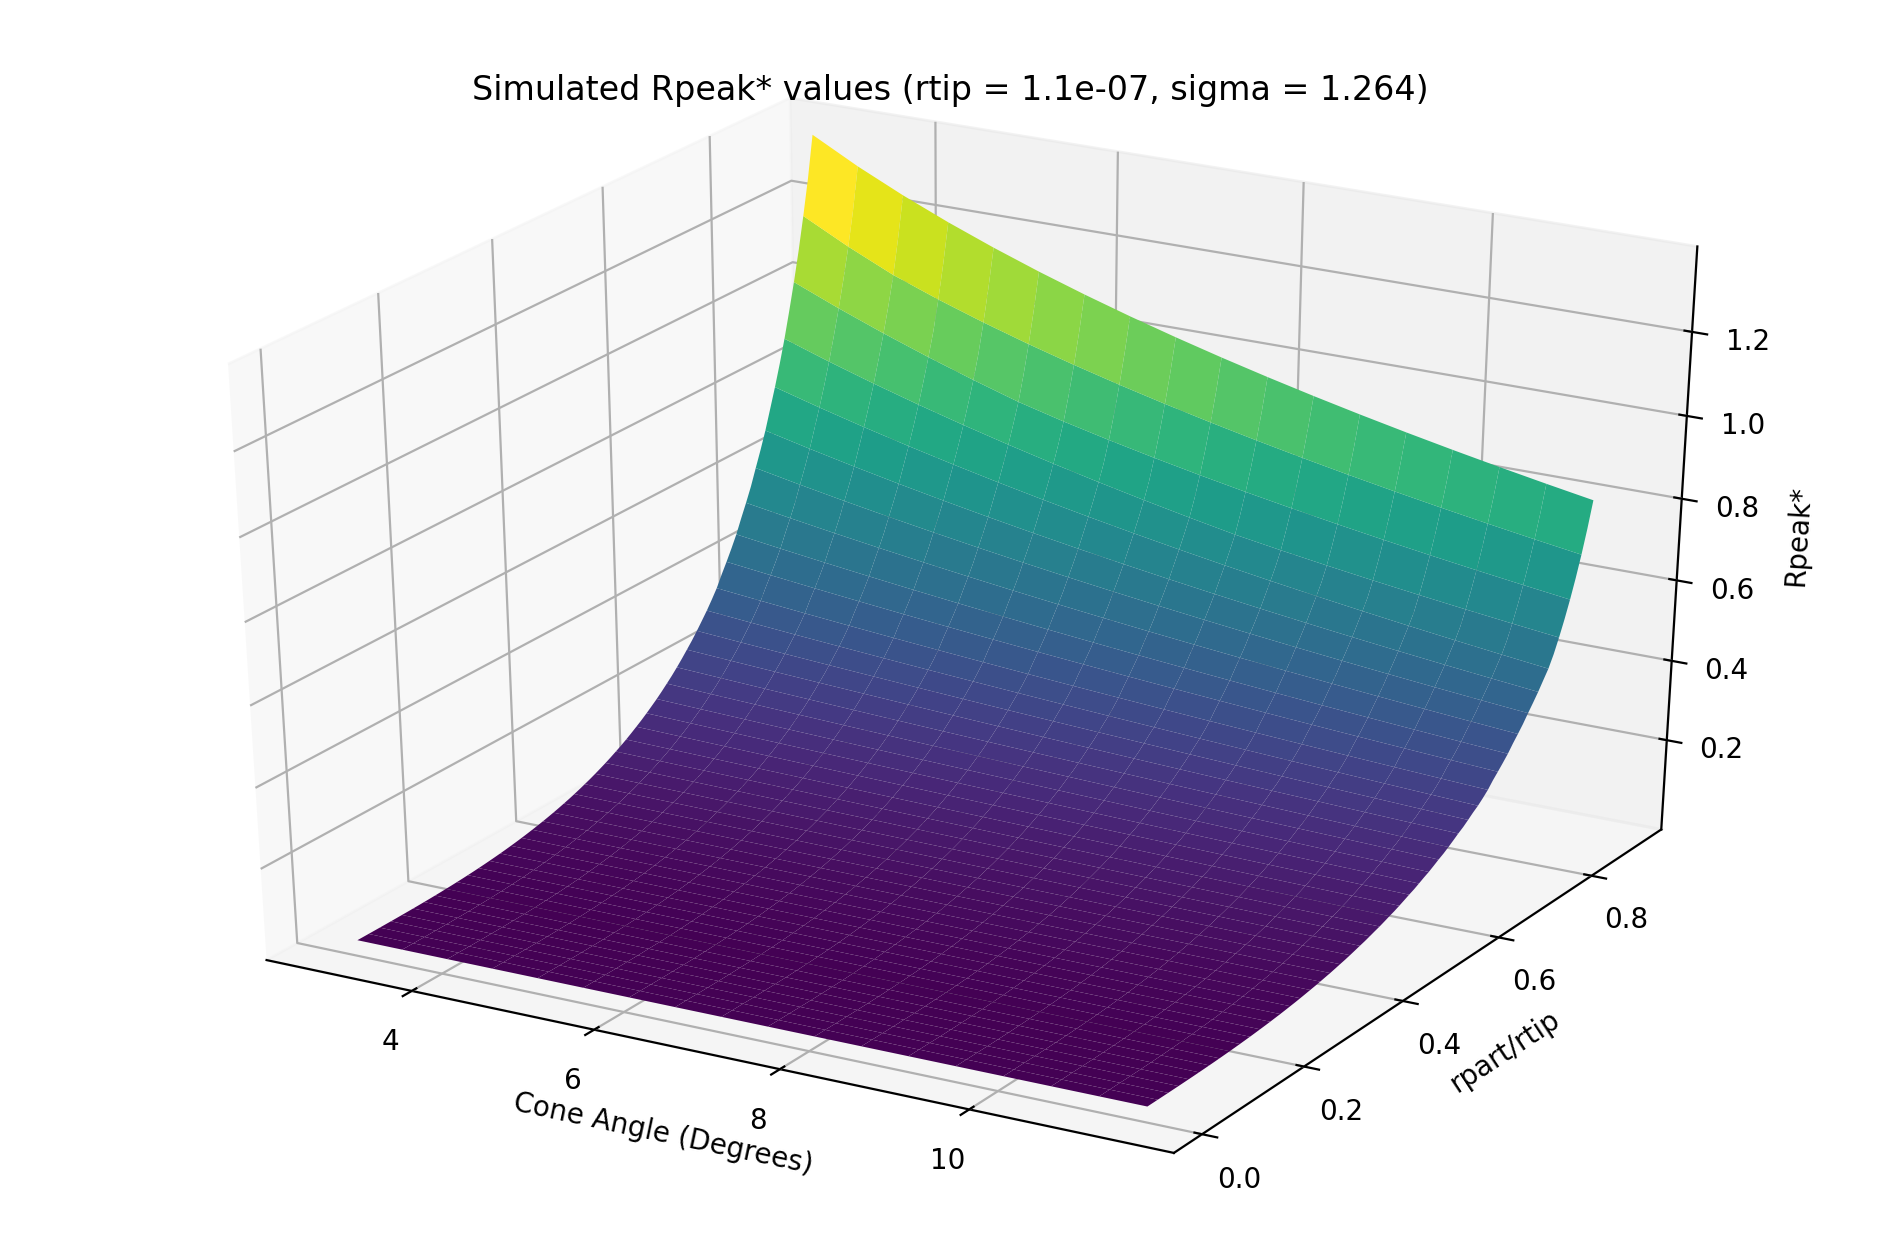

In [33]:
plot_Rpeak_surface(110e-9, test_sig)

## *Part 4 - Curve Fitting* 

In [40]:
X, Y = np.meshgrid(size, ang)
Z = rpeak

X = X.flatten()
Y = Y.flatten()

A = np.array([X**0*Y**0, X, Y, X**2, X*Y, Y**2, X**3, X**2*Y, X*Y**2, 
             Y**3, X**4, X**3*Y, X**2*Y**2, X*Y**3, Y**4, X**5, X**4*Y,
             X**3*Y**2, X**2*Y**3, X*Y**4, Y**5, X**6, X**5*Y, X**4*Y**2,
             X**3*Y**3, X**2*Y**4, X*Y**5, Y**6, X**7, X**6*Y, X**5*Y**2,
             X**4*Y**3, X**3*Y**4, X**2*Y**5, X*Y**6, Y**7, X**8,
             X**7*Y, X**6*Y**2, X**5*Y**3, X**4*Y**4, X**3*Y**5,
             X**2*Y**6, X*Y**7, Y**8]).T
B = Z.flatten()

coeff, r, rank, s = np.linalg.lstsq(A, B)

/home/mcalli75/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


In [41]:
coeff

array([-4.42069909e-02, -3.10185746e-01,  2.78726395e-02,  8.00689001e+00,
       -5.50216363e-02,  2.68643415e-03, -7.85537029e+01,  7.28147992e-01,
        3.68076037e-03, -5.98544356e-03,  3.78753456e+02, -2.94657403e+00,
       -5.64080653e-02, -2.35628123e-03,  2.08835534e-03, -9.56654996e+02,
        2.52210096e+00,  4.08096981e-01, -3.38642991e-03,  8.69602753e-04,
       -3.60471787e-04,  1.31488270e+03,  7.16005213e+00, -1.07732506e+00,
        1.11312586e-02, -3.27605787e-04, -1.06721020e-04,  3.41380032e-05,
       -9.30392312e+02, -1.37469457e+01,  9.98356455e-01,  6.75174758e-03,
       -9.79036631e-04,  6.64176012e-05,  5.33002243e-06, -1.69031260e-06,
        2.68946052e+02,  5.69774799e+00, -1.80862975e-01, -2.03616681e-02,
        9.91408021e-04, -6.22866883e-06, -2.22607369e-06, -8.57672831e-08,
        3.41631225e-08])